In [47]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"

display(HTML('<style>.container {width:90% !important;}</style>'))

from datetime import datetime, date, timedelta
import json
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use('fivethirtyeight')
%matplotlib inline

In [48]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

In [49]:
os.chdir('../football_data')

In [50]:
lines_df = pd.read_csv('all_lines.csv', index_col='Unnamed: 0')
games_df = pd.read_csv('game_metadata.csv')

In [51]:
lines_df.shape
games_df.shape

(2937, 26)

(2937, 23)

#### standardize dates

In [52]:
lines_df['Date'] = lines_df['Date'].apply(pd.to_datetime)

games_df['day_of_week'] = games_df['date'].apply(pd.to_datetime).dt.dayofweek
games_df['date'] = games_df['date'].apply(pd.to_datetime)

#### Standardize team names for lines table

In [53]:
team_map = json.load(open('team_map_for_lines.json','r'))
for i, (k,v) in enumerate(team_map.iteritems()):
    print '{} --> {}'.format(k, v)
    if i == 5:
        break
        
for field in ['V_Team','H_Team']:
    lines_df[field] = lines_df[field].map(team_map)

Dallas --> Cowboys
NewYork --> Giants
NYGiants --> Giants
Minnesota --> Vikings
Denver --> Broncos
NewEngland --> Patriots


#### Prepare to join the tables
* key is (date, team first alphabetically)
* game on neutral territory can cause problems, e.g. superbowl

In [54]:
def cast_dtypes(df):
    '''spark and numpy types don't play
    well together. cast as native python 
    types'''
    np_to_python_dtypes = {
        'int64': int,
        'float64': float,
        'object': str,
        'datetime64[ns]': str
    }

    for field, np_dtype in df.dtypes.to_dict().iteritems():
        df[field] = df[field].astype(np_to_python_dtypes[str(np_dtype)])
        
    return df


games_df = cast_dtypes(games_df)
lines_df = cast_dtypes(lines_df)

In [55]:
def gen_game_key(x):
    '''generates a key for each game:
    (first alphabetical team name, date)'''
    team_a, team_b, dt = x
    return (sorted([team_a, team_b])[0], dt)

games_key_fields = ['team0_name','team1_name','date']
lines_key_fields = ['H_Team','V_Team', 'Date']

games_df['key'] = games_df[games_key_fields].apply(gen_game_key, axis=1)
lines_df['key'] = lines_df[lines_key_fields].apply(gen_game_key, axis=1)
    
games_lines_df = games_df.merge(
        lines_df, left_on='key', right_on='key'
    ).drop(
        lines_key_fields, axis=1
    )

## ensure there are no join misses
assert lines_df.shape[0] == games_df.shape[0]
assert games_lines_df.shape[0] == games_df.shape[0]

### form game info

In [56]:
## get the path for each game_info csv
game_info_csvs = map(
    lambda x: 'game_info/{}'.format(x), 
    os.listdir('game_info')
)
## read each game_info csv into pandas
game_info_dfs = map(
    lambda x: pd.read_csv(x, index_col='Unnamed: 0'), 
    game_info_csvs
)
## union all the DFs
game_info_df = reduce(
    lambda x,y: x.append(y).reset_index(drop=True), 
    game_info_dfs
)

In [57]:
game_info_df['key_value'] = game_info_df[['info','stat']].apply(
    lambda (k,v): {k:v}, axis=1
)

game_info_dict = {}
for game in game_info_df['game_id'].unique():
    curr_game_df = game_info_df[game_info_df['game_id'] == game]
    game_info_dict[game] = {
            d.keys()[0]:d.values()[0] 
            for d in curr_game_df['key_value'].values
        }

In [58]:
game_info_colnames = {
    'Vegas Line': 'pfr_line',
    'Over/Under': 'pfr_ou',
    'Weather': 'prf_weather',
    'Roof': 'roof',
    'Surface': 'surface'
}

game_info = pd.DataFrame.from_dict(game_info_dict, orient='index')\
                .rename(columns=game_info_colnames)\
                .drop(['Won Toss','Won OT Toss','Super Bowl MVP'], axis=1)

In [59]:
games_lines_info = games_lines_df.merge(game_info, left_on='game_id', right_index=True)

#### assert there are no join misses

In [60]:
assert games_lines_df.shape[0] == game_info.shape[0]
assert games_lines_df.shape[0] == games_lines_info.shape[0]

### Get the week #

In [61]:
## day of week -- 0==Monday, 6==Sunday
## game's date minus day of week --> week number
## since Monday games

def npdate_to_str(dt):
    '''convert np.datetime64 to 
    YYYY-MM-DD string'''
    return str(dt).split(' ')[0]

def make_week_id(x):
    '''given a date and day of week,
    return the "week id" which is the
    Sunday of that week. Monday (0) winds back
    a day. otherwise move toward Sunday (6).
    '''
    dt_str, dow = x
    dt = datetime.strptime(dt_str, '%Y-%m-%d')
    if dow == 6:
        week_id = dt
    elif dow == 0:
        week_id = dt - timedelta(days=1)
    else:
        delta = 6 - dow
        week_id = dt + timedelta(days=delta)
    
    return npdate_to_str(week_id)
    
games_lines_df['week_id'] = games_lines_df[['date','day_of_week']]\
                                .apply(make_week_id, axis=1)

In [62]:
season_to_week = {}
for season in games_lines_df['Season'].unique():
    season_to_week[season] = {}
    weeks = games_lines_df[games_lines_df['Season'] == season]['week_id'].unique()
    for i, wk in enumerate(sorted(weeks)):
        season_to_week[season][wk] = i

In [63]:
games_lines_df['week_id'] = games_lines_df[['Season','week_id']].apply(
        lambda x: season_to_week[x[0]][x[1]], axis=1
    )

In [64]:
stadiums = pd.read_csv('stadium_lat_long.csv')

In [65]:
before = games_lines_df.shape[0]
games_lines_df = games_lines_df.merge(
        stadiums, left_on='stadium', right_on='stadium'
    )
assert games_lines_df.shape[0] == before

### Divisions

In [66]:
divisions_df = pd.read_csv('team_divisions.csv', index_col='idx')

In [67]:
before = games_lines_df.shape[0]
for nteam in [0,1]:
    games_lines_df = games_lines_df.merge(
        divisions_df.rename(
            columns={'division': 'team{}_division'.format(nteam)}
        ),
        left_on=['Season','team{}_fullname'.format(nteam)],
        right_on=['season','team']
    ).drop(['season','team'], axis=1)
    assert games_lines_df.shape[0] == before

In [68]:
games_lines_df[['team0_fullname','team0_division','team1_fullname','team1_division']].head()

,team0_fullname,team0_division,team1_fullname,team1_division
0,New England Patriots,AFC East,Philadelphia Eagles,NFC East
1,Los Angeles Rams,NFC West,Philadelphia Eagles,NFC East
2,Kansas City Chiefs,AFC West,Philadelphia Eagles,NFC East
3,Seattle Seahawks,NFC West,Philadelphia Eagles,NFC East
4,Los Angeles Chargers,AFC West,Philadelphia Eagles,NFC East


### Normalize DataFrame into 5 tables + add DVOA table:
* team-season
* game
* coach
* stadium
* line
* DVOA
* eventually a 7th for player

In [69]:
games_lines_df = games_lines_df.rename(columns={
        'Season':'season'
    })

In [122]:
## Table: team_season
team_season_fields = [
    'season',
    'team0_link','team0_name','team0_fullname','team0_city','team0_division',
    'team1_link','team1_name','team1_fullname','team1_city','team1_division'
]
## Table: coach
coach_fields = [
    'team0_coach_raw','team0_coach_name','team0_coach_id',
    'team1_coach_raw','team1_coach_name','team1_coach_id'
]
## Table: game
game_fields = [
    'team0_link','team0_score','team0_coach_id',
    'team1_link','team1_score','team1_coach_id',
    'date','time','day_of_week','season','week_id',
    'stadium','attendance','duration','game_id',
    'H_Q1','H_Q2','H_Q3','H_Q4','V_Q1','V_Q2','V_Q3','V_Q4'
]
## Table: stadium
stadium_fields = [
    'stadium','stadium_link','lat','long'
]
## Table: line
line_fields = [
   'game_id','H_Final','V_Final','H_ML','V_ML','ML_Fav','Open_Fav','Open_OU',
   'Open_Spread','Close_Fav','Close_OU','Close_Spread','2H_Fav','2H_OU',
   '2H_Spread'
]

In [123]:
## union team0 and team1 fields and get distinct values
def combine_team0_team1(full_df, all_fields, non_team_fields):
    '''given a DataFrame with 2 teams:
    * split into 2 DFs by team0 and team1
    * rename and align schemas
    * union
    * drop duplicates
    * return a DataFrame to be converted into Hive table'''

    for team_i in [0,1]:
        fields = [
            a for a in all_fields
            if 'team{}'.format(team_i) in a
        ]
        curr_table = full_df[non_team_fields + fields]
        ## team out team0 and team1 to align schemas
        field_map = dict(map(
                lambda x: (x, x.replace('team{}_'.format(team_i), '')),
                fields
            ))
        curr_table = curr_table.rename(columns=field_map)

        if team_i == 0:
            curr_df = curr_table
        else:
            curr_df = curr_df.append(
                curr_table[curr_df.columns]
            ).reset_index(drop=True)

    return curr_df.drop_duplicates()

#### game
* __fact table__
* primary key is game_id
* TODO ASAP: need to sort out home/away
 * goes the game_id contain the home team?
 * does this hold true for games in neutral territory?

In [126]:
game_df = games_lines_df[game_fields].drop_duplicates()

## assert coach ID is unique
assert game_df['game_id'].value_counts().max() == 1
game_df.head().T

,0,1,2,3,4
team0_link,/teams/nwe/2017.htm,/teams/ram/2017.htm,/teams/kan/2017.htm,/teams/sea/2017.htm,/teams/sdg/2017.htm
team0_score,33,35,27,24,24
team0_coach_id,/coaches/BeliBi0.htm,/coaches/McVaSe0.htm,/coaches/ReidAn0.htm,/coaches/CarrPe0.htm,/coaches/LynnAn0.htm
team1_link,/teams/phi/2017.htm,/teams/phi/2017.htm,/teams/phi/2017.htm,/teams/phi/2017.htm,/teams/phi/2017.htm
team1_score,41,43,20,10,26
team1_coach_id,/coaches/PedeDo0.htm,/coaches/PedeDo0.htm,/coaches/PedeDo0.htm,/coaches/PedeDo0.htm,/coaches/PedeDo0.htm
date,2018-02-04,2017-12-10,2017-09-17,2017-12-03,2017-10-01
time,6:30pm,4:25pm,1:00pm,8:30pm,4:05pm
day_of_week,6,6,6,6,6
season,2017,2017,2017,2017,2017


#### team_season
* primary key is (season, link)
* joins with game

In [118]:
team_season_df = combine_team0_team1(
    games_lines_df.copy(), team_season_fields, ['season']
)
## assert that every season has the same amount of teams
assert team_season_df['season'].value_counts().min() \
        == team_season_df['season'].value_counts().max()

## assert key (season, link) is unique
assert team_season_df.groupby(['season','link']).size().max() == 1
team_season_df.head()

,season,link,name,fullname,city,division
0,2017,/teams/nwe/2017.htm,Patriots,New England Patriots,New England,AFC East
1,2017,/teams/ram/2017.htm,Rams,Los Angeles Rams,Los Angeles,NFC West
2,2017,/teams/kan/2017.htm,Chiefs,Kansas City Chiefs,Kansas City,AFC West
3,2017,/teams/sea/2017.htm,Seahawks,Seattle Seahawks,Seattle,NFC West
4,2017,/teams/sdg/2017.htm,Chargers,Los Angeles Chargers,Los Angeles,AFC West


#### coach
* primary key is coach_id
* joins with game

In [119]:
coach_df = combine_team0_team1(games_lines_df.copy(), coach_fields, [])

## assert coach ID is unique
assert coach_df['coach_id'].value_counts().max() == 1
coach_df.head()

,coach_raw,coach_name,coach_id
0,"<a href=""/coaches/BeliBi0.htm"">Bill Belichick</a>",Bill Belichick,/coaches/BeliBi0.htm
1,"<a href=""/coaches/McVaSe0.htm"">Sean McVay</a>",Sean McVay,/coaches/McVaSe0.htm
2,"<a href=""/coaches/ReidAn0.htm"">Andy Reid</a>",Andy Reid,/coaches/ReidAn0.htm
3,"<a href=""/coaches/CarrPe0.htm"">Pete Carroll</a>",Pete Carroll,/coaches/CarrPe0.htm
4,"<a href=""/coaches/LynnAn0.htm"">Anthony Lynn</a>",Anthony Lynn,/coaches/LynnAn0.htm


#### stadiums
* primary key is stadium name
* joins with game

In [108]:
stadium_df = games_lines_df[stadium_fields].drop_duplicates()
## assert stadium name is unique
assert stadium_df['stadium'].value_counts().max() == 1
stadium_df.head()

,stadium,stadium_link,lat,long
0,U.S. Bank Stadium,/stadiums/MIN01.htm,44.97400,-93.25800
1,Los Angeles Memorial Coliseum,/stadiums/LAX99.htm,34.01417,-118.28778
2,Arrowhead Stadium,/stadiums/KAN00.htm,39.04889,-94.48389
3,CenturyLink Field,/stadiums/SEA00.htm,47.59520,-122.33160
4,StubHub Center,/stadiums/LAX97.htm,33.86400,-118.26100


#### line
* primary key is game_id
* joins with game
* TODO ASAP: need to go back and figure out how to get home team
   * for most games it's easy but what about neutral territory games?

In [111]:
line_df = games_lines_df[line_fields].drop_duplicates()
## assert game ID is unique
assert line_df['game_id'].value_counts().max() == 1
line_df.head().T

,0,1,2,3,4
game_id,201802040nwe,201712100ram,201709170kan,201712030sea,201710010sdg
H_Final,33,35,27,24,24
V_Final,41,43,20,10,26
H_ML,-200,105,-200,180,-130
V_ML,170,-125,170,-220,110
ML_Fav,H,V,H,V,H
Open_Fav,H,H,H,V,H
Open_OU,47.5,51,47.5,46.5,46.5
Open_Spread,6,1,4.5,3.5,1
Close_Fav,H,V,H,V,H


#### DVOA
* primary key is (team, season)
* joins with team_season and game

In [177]:
dvoa_df = pd.read_csv('dvoa/dvoa_alltime.csv', index_col='Unnamed: 0').loc[
        :, ['DEFENSEDVOA','OFFENSEDVOA','S.T.DVOA','TEAM',
            'TOTALDVOA','TOTAL DAVE','WEIGHTEDDVOA','Year','Week']
    ].rename(
        columns={'Year':'season', 'Week':'week','TEAM':'name'}
    )
## headers are in data from appending dataframes. filter them out
dvoa_df = dvoa_df[~dvoa_df['OFFENSEDVOA'].str.contains('OFFENSE')]
dvoa_df.shape

(5632, 9)

In [178]:
team_season_years = set(team_season_df['season'].value_counts().index)
dvoa_years = set(dvoa_df['season'].value_counts().index)

## assert years perfectly overlap
assert team_season_years == dvoa_years

In [179]:
team_season_teams = set(team_season_df['name'].value_counts().index)
dvoa_teams = set(dvoa_df['name'].value_counts().index)

## assert years perfectly overlap
assert team_season_teams == dvoa_teams

In [182]:
#### assert that it joins cleanly with game table
dvoa_size = dvoa_df.shape[0]
team_season_size = team_season_df.shape[0]

key = ['name','season']
join_size = dvoa_df.merge(team_season_df, left_on=key, right_on=key).shape[0]

## assert that dvoa_df hits all joins with team_season_df
assert dvoa_size == join_size

AssertionError: 

TODO: week 4 of 2008 has names missing. probably HTML issue
* resolve the above assertion when done

In [181]:
tmp = dvoa_df.merge(team_season_df, left_on=key, right_on=key, how='left')
tmp[tmp['link'].isnull()]

,DEFENSEDVOA,OFFENSEDVOA,S.T.DVOA,name,TOTALDVOA,TOTAL DAVE,WEIGHTEDDVOA,season,week,link,fullname,city,division
608,-52.9%,8.9%,-1.2%,NaN,60.6%,20.4%,NaN,2008,4,NaN,NaN,NaN,NaN
609,-8.1%,29.4%,4.6%,NaN,42.1%,22.3%,NaN,2008,4,NaN,NaN,NaN,NaN
610,-26.9%,11.4%,0.2%,NaN,38.5%,36.4%,NaN,2008,4,NaN,NaN,NaN,NaN
611,-39.3%,-0.3%,-4.2%,NaN,34.7%,19.8%,NaN,2008,4,NaN,NaN,NaN,NaN
612,-26.4%,-3.9%,1.3%,NaN,23.8%,22.2%,NaN,2008,4,NaN,NaN,NaN,NaN
613,-10.6%,7.7%,5.1%,NaN,23.4%,8.2%,NaN,2008,4,NaN,NaN,NaN,NaN
614,-1.1%,25.7%,-3.8%,NaN,23.0%,10.1%,NaN,2008,4,NaN,NaN,NaN,NaN
615,11.8%,31.8%,-0.3%,NaN,19.8%,16.5%,NaN,2008,4,NaN,NaN,NaN,NaN
616,-21.0%,-6.9%,2.1%,NaN,16.2%,10.9%,NaN,2008,4,NaN,NaN,NaN,NaN
617,3.5%,18.3%,0.3%,NaN,15.1%,19.7%,NaN,2008,4,NaN,NaN,NaN,NaN


### Cast from Numpy types to Python native types in order to conver to Spark DF and subsequently write as table

In [185]:
lines_sdf = spark.createDataFrame(
        cast_dtypes(lines_df)
    ).withColumn(
        'Date', col('Date').cast(DateType())
    ).write.mode('overwrite').saveAsTable('lines')

games_lines_sdf = spark.createDataFrame(
        games_lines_df
    ).withColumn(
        'date', col('date').cast(DateType())
    ).write.mode('overwrite').saveAsTable('games_lines')

for sdf_ in ['games','game_info']:
    _ = spark.sql('refresh table {}'.format(sdf_))
    
games_lines = spark.table('games_lines').cache()
game_info = spark.table('game_info').cache()

AnalysisException: u"Table or view 'games' not found in database 'default';"

In [184]:
games_lines.toPandas()['Open_Spread']\
    .value_counts()\
    .sort_index()\
    .plot(kind='bar', figsize=(12,8), color='#99d8c9')

NameError: name 'games_lines' is not defined

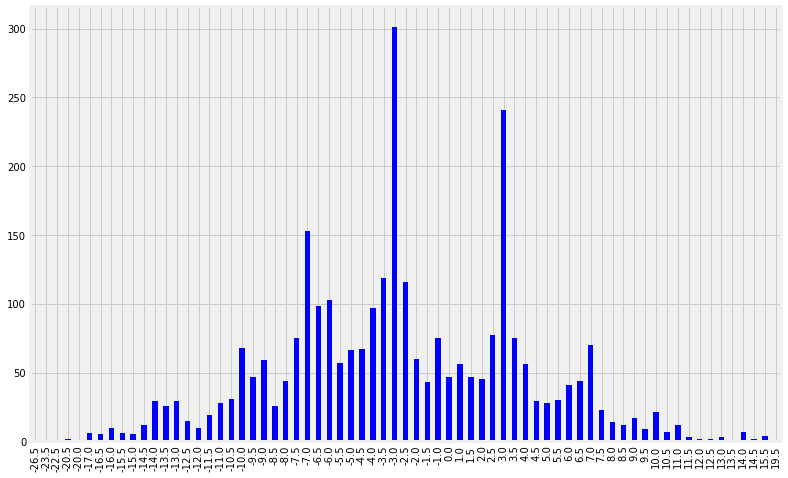

In [140]:
(games_lines.toPandas()['Close_Spread'] 
  * games_lines.toPandas()['Close_Fav'].apply(lambda x: -1 if x == 'H' else 1)
).value_counts().sort_index().plot(kind='bar', figsize=(12,8), color='blue')